<a href="https://colab.research.google.com/github/sundar911/retail_analytics/blob/main/demand_forecasting__final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_stores = pd.read_csv('/content/drive/MyDrive/stores data-set.csv')
df_features = pd.read_csv('/content/drive/MyDrive/Features data set.csv', parse_dates = ['Date'])
df_sales = pd.read_csv('/content/drive/MyDrive/sales data-set.csv', parse_dates = ['Date'])

## Cleaning and preprocessing

In [ ]:
df_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [ ]:
df_sales.Date.value_counts()

2011-12-23    3027
2011-11-25    3021
2011-12-16    3013
2011-09-12    3010
2012-02-17    3007
              ... 
2010-09-07    2903
2010-08-20    2901
2010-07-16    2901
2010-08-27    2898
2010-08-13    2896
Name: Date, Length: 143, dtype: int64

In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [ ]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
df_features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

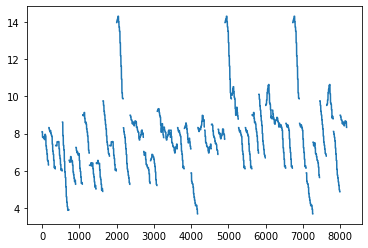

In [ ]:
df_features.Unemployment.plot();

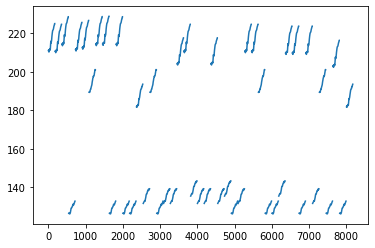

In [ ]:
df_features.CPI.plot();

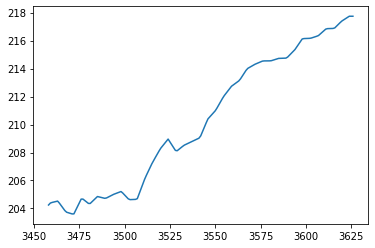

In [ ]:
df_features[df_features.Store == 20].CPI.plot();

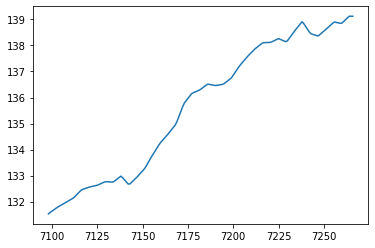

In [ ]:
df_features[df_features.Store == 40].CPI.plot();

In [ ]:
df_features[df_features.CPI.isna()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-03-05,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-10-05,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-05-07,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-12-07,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


Not wise to impute in missing values for the markdown columns as they have a lot of missing values. Considering only about 5% of CPI and Unemployment values are missing, we can look to impute in the missing values. 

In [4]:
for i in range(1,46):
  df_features[df_features.Store == i]= df_features[df_features.Store == i].interpolate()

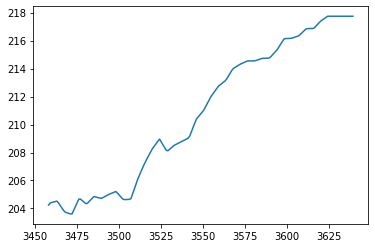

In [ ]:
df_features[df_features.Store == 20].CPI.plot();

In [ ]:
df_features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4140
MarkDown2       4140
MarkDown3       4143
MarkDown4       4188
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

In [5]:
df_features[df_features.columns[4:9]] = df_features[df_features.columns[4:9]].fillna(0)

In [ ]:
df_features.isna().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [ ]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Merging features and sales on column columns (Date, Store and IsHoliday) coupled with a right join on sales. This is because sales has data till 2012 but features has data till 2013 so let's train our model on the data till 2012 and forecast the 2013 data. 

In [6]:
df_all_1 = df_features.merge(df_sales, 'right', on = ['Date', 'Store', 'IsHoliday'])

In [ ]:
df_all_1

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales
0,1,2010-05-02,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,1,24924.50
1,1,2010-05-02,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,2,50605.27
2,1,2010-05-02,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,3,13740.12
3,1,2010-05-02,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,4,39954.04
4,1,2010-05-02,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,5,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,97,6817.48


Merging sales+features with stores 

In [7]:
df_all = df_all_1.merge(df_stores, 'left', on = 'Store')

In [8]:
df_all = df_all.sort_values('Date')

In [9]:
df_all.reset_index(inplace = True)

In [10]:
df_all.drop(['index'], axis = 1, inplace = True)

In [11]:
df_all.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,13,2010-01-10,68.74,2.853,0.0,0.0,0.0,0.0,0.0,126.234600,7.795,False,14,20922.18,A,219622
1,40,2010-01-10,62.01,2.717,0.0,0.0,0.0,0.0,0.0,132.756800,5.287,False,74,9872.41,A,155083
2,40,2010-01-10,62.01,2.717,0.0,0.0,0.0,0.0,0.0,132.756800,5.287,False,79,10840.77,A,155083
3,27,2010-01-10,70.19,2.840,0.0,0.0,0.0,0.0,0.0,136.629757,8.021,False,98,9837.86,A,204184
4,27,2010-01-10,70.19,2.840,0.0,0.0,0.0,0.0,0.0,136.629757,8.021,False,97,19095.76,A,204184


In [ ]:
df_all.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Dept,Weekly_Sales,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,44.260317,15981.258123,136727.915739
std,12.785297,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,30.492054,22711.183519,60980.583328
min,1.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,-4988.940000,34875.000000
25%,11.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,18.000000,2079.650000,93638.000000
50%,22.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,37.000000,7612.030000,140167.000000
75%,33.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,74.000000,20205.852500,202505.000000
max,45.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,99.000000,693099.360000,219622.000000


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  IsHoliday     421570 non-null  bool          
 12  Dept          421570 non-null  int64         
 13  Weekly_Sales  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [ ]:
df_all_copy = df_all.copy()

In [12]:
mapping_dict = {'IsHoliday':{True:1, False:0}}
df_all.replace(mapping_dict, inplace=True)
mapping_dict_1 = {'Type':{'A':3, 'B':2, 'C':1}}
df_all.replace(mapping_dict_1, inplace=True)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  IsHoliday     421570 non-null  int64         
 12  Dept          421570 non-null  int64         
 13  Weekly_Sales  421570 non-null  float64       
 14  Type          421570 non-null  int64         
 15  Size          421

In [ ]:
df_all.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,13,2010-01-10,68.74,2.853,0.0,0.0,0.0,0.0,0.0,126.234600,7.795,0,14,20922.18,3,219622
1,40,2010-01-10,62.01,2.717,0.0,0.0,0.0,0.0,0.0,132.756800,5.287,0,74,9872.41,3,155083
2,40,2010-01-10,62.01,2.717,0.0,0.0,0.0,0.0,0.0,132.756800,5.287,0,79,10840.77,3,155083
3,27,2010-01-10,70.19,2.840,0.0,0.0,0.0,0.0,0.0,136.629757,8.021,0,98,9837.86,3,204184
4,27,2010-01-10,70.19,2.840,0.0,0.0,0.0,0.0,0.0,136.629757,8.021,0,97,19095.76,3,204184


# EDA

### Setting up for some time series analysis

In [13]:
df_by_date = df_all.groupby('Date', as_index=False).agg({'Temperature': 'mean',
                                                        'Fuel_Price': 'mean',
                                                        'CPI': 'mean',
                                                        'Unemployment': 'mean', 
                                                        'Weekly_Sales': 'sum',
                                                        'IsHoliday': 'mean'})

In [14]:
df_by_date.Date = pd.to_datetime(df_by_date.Date, errors='coerce')
df_by_date.set_index('Date', inplace=True)

In [15]:
df_by_date.head()

,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday
Date,,,,,,
2010-01-10,69.386998,2.733064,168.004935,8.433960,42239875.87,0
2010-02-04,52.587887,2.825453,167.377836,8.441092,50423831.26,0
2010-02-07,76.555955,2.793190,167.663264,8.373801,48917484.50,0
2010-02-19,37.038310,2.673666,167.338966,8.576351,48276993.78,0
2010-02-26,38.629563,2.685642,167.691019,8.561375,43968571.13,0


resampling (weekly, backfill) with some dummy dates in the middle as the above data doesn't have a definitive frequency 

In [16]:
df_by_date_new = df_by_date.resample('W').mean().fillna(method='bfill')

In [17]:
df_by_date_new[0:10]

,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday
Date,,,,,,
2010-01-10,69.386998,2.733064,168.004935,8.433960,4.223988e+07,0.0
2010-01-17,64.571921,2.809321,167.520550,8.407446,4.967066e+07,0.0
2010-01-24,64.571921,2.809321,167.520550,8.407446,4.967066e+07,0.0
2010-01-31,64.571921,2.809321,167.520550,8.407446,4.967066e+07,0.0
2010-02-07,64.571921,2.809321,167.520550,8.407446,4.967066e+07,0.0
2010-02-14,37.038310,2.673666,167.338966,8.576351,4.827699e+07,0.0
2010-02-21,37.038310,2.673666,167.338966,8.576351,4.827699e+07,0.0
2010-02-28,38.629563,2.685642,167.691019,8.561375,4.396857e+07,0.0
2010-03-07,58.629843,2.816753,167.988959,8.405245,4.855164e+07,0.0


### Decomposing

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Seasonal Decompose gives the decomposition of the time series into its estimated trend component, estimated seasonal component, and estimated residual. We can also plot the original data to look at what components of the data influence its true value the most.  

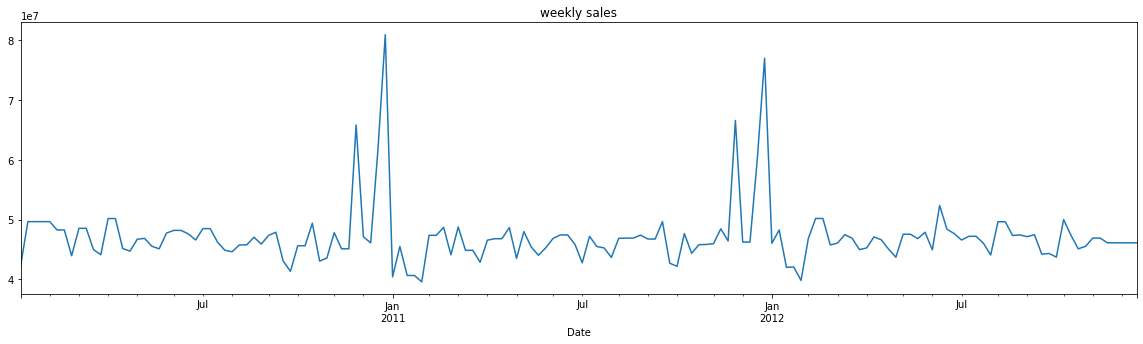

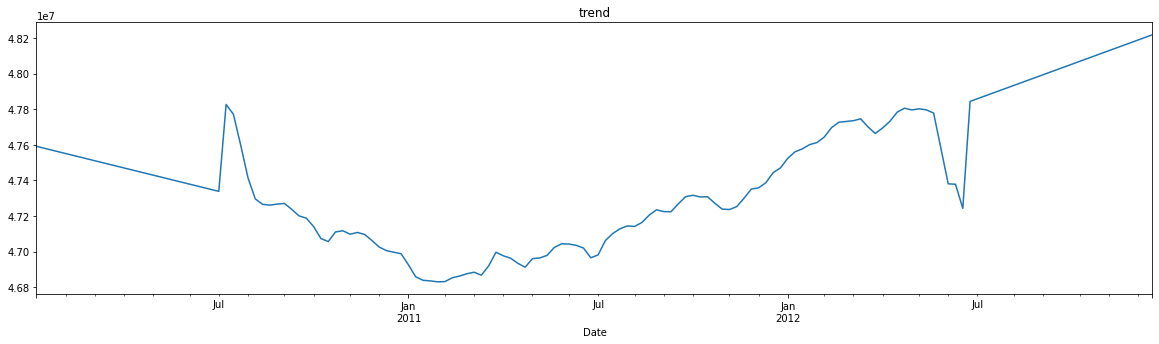

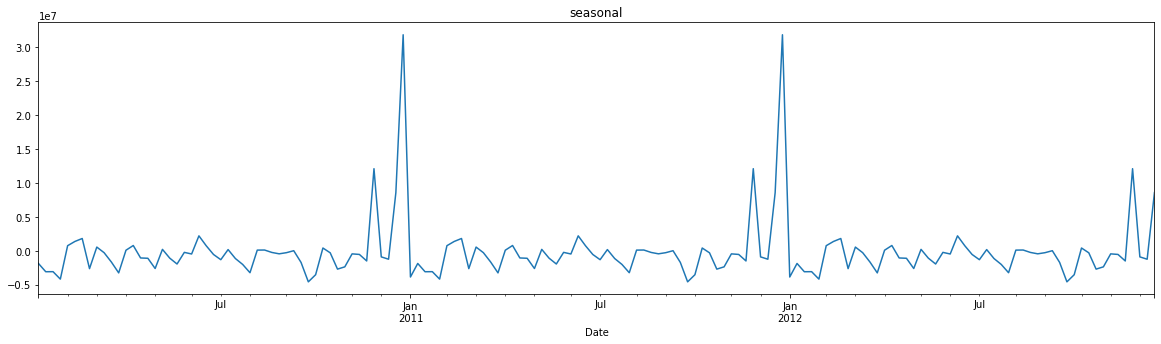

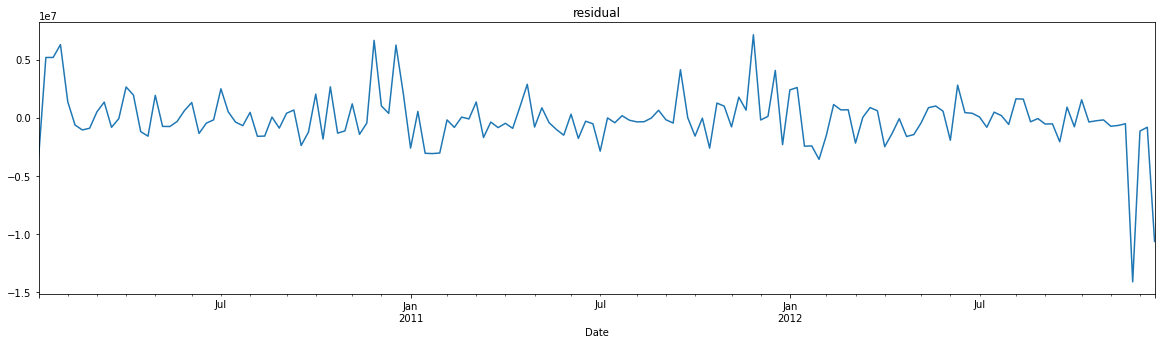

In [19]:
multi_plot = seasonal_decompose(df_by_date_new['Weekly_Sales'], model = 'add', extrapolate_trend='freq')

plt.figure(figsize=(20,5))
multi_plot.observed.plot(title = 'weekly sales')

plt.figure(figsize=(20,5))
multi_plot.trend.plot(title = 'trend')

plt.figure(figsize=(20,5))
multi_plot.seasonal.plot(title = 'seasonal')

plt.figure(figsize=(20,5))
multi_plot.resid.plot(title = 'residual');

As it can be observed, the series is strongly influenced by the seasonal component 

### Correlations

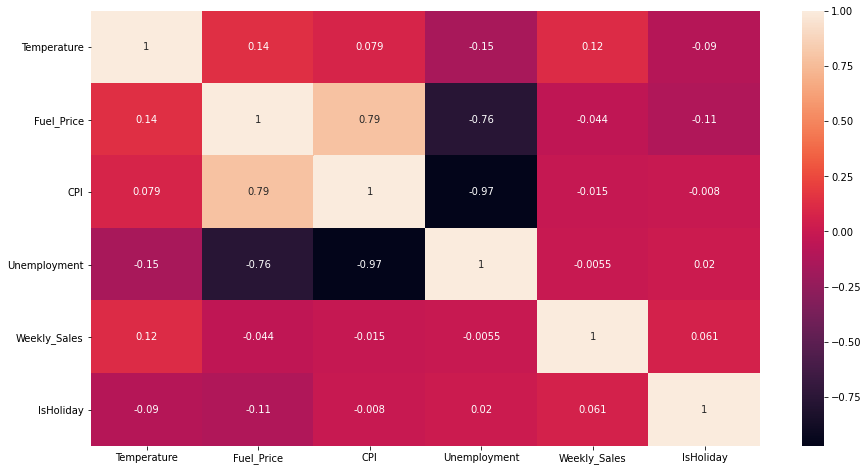

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df_by_date_new.corr('spearman'), annot = True);

strong +ve correlation b/w Fuel_Price and CPI and strong -ve correlations b/w Unmeployment and Fuel_Price and Unemployment and CPI. surprisingly, unemployment rate doesn't really seem to affect the weekly sales (directly at least)

### Holiday weeks

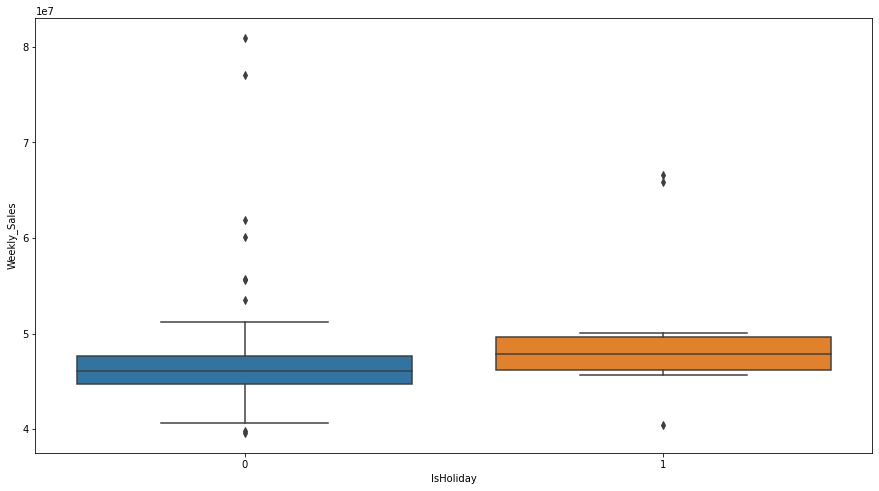

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data = df_by_date, x = 'IsHoliday', y = 'Weekly_Sales');

holiday weeks don't necessarily mean that the weekly sales go up but it is often the case

###Analysis by store

In [ ]:
df_by_store = df_all.groupby('Store').agg({'Temperature': 'mean',
                                           'Fuel_Price': 'mean',
                                           'CPI': 'mean',
                                           'Unemployment': 'mean', 
                                           'Weekly_Sales': 'sum',
                                           'IsHoliday': 'mean',
                                           'Type': 'max'})

In [ ]:
df_by_store.describe()

,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday,Type
count,45.000000,45.000000,45.000000,45.000000,4.500000e+01,45.000000,45.000000
mean,60.620223,3.360718,171.595976,7.995321,1.497160e+08,0.070326,2.355556
std,9.806327,0.150153,39.664650,1.786202,7.816756e+07,0.000439,0.712089
min,39.602815,3.210664,128.663519,4.793244,3.716022e+07,0.069248,1.000000
25%,53.291597,3.220912,135.087130,7.004905,7.956575e+07,0.070050,2.000000
50%,58.413297,3.288495,186.287850,7.860290,1.382498e+08,0.070376,2.000000
75%,69.639935,3.443894,214.872865,8.585175,1.996139e+08,0.070598,3.000000
max,76.798159,3.617363,219.683641,13.116094,3.013978e+08,0.071270,3.000000


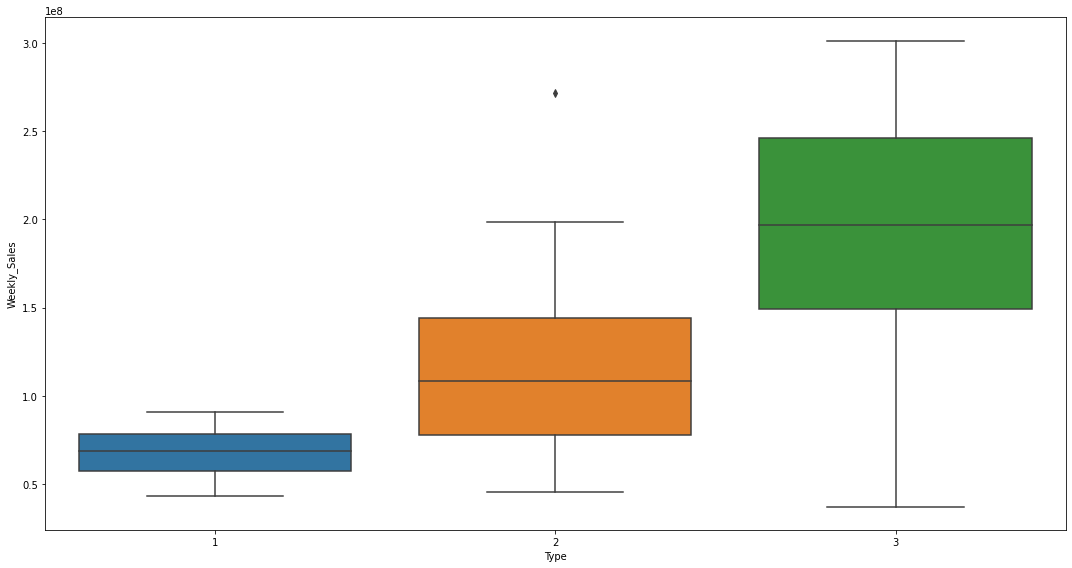

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data = df_by_store, x = 'Type', y = 'Weekly_Sales')
plt.tight_layout()

###Net sales (monthly)

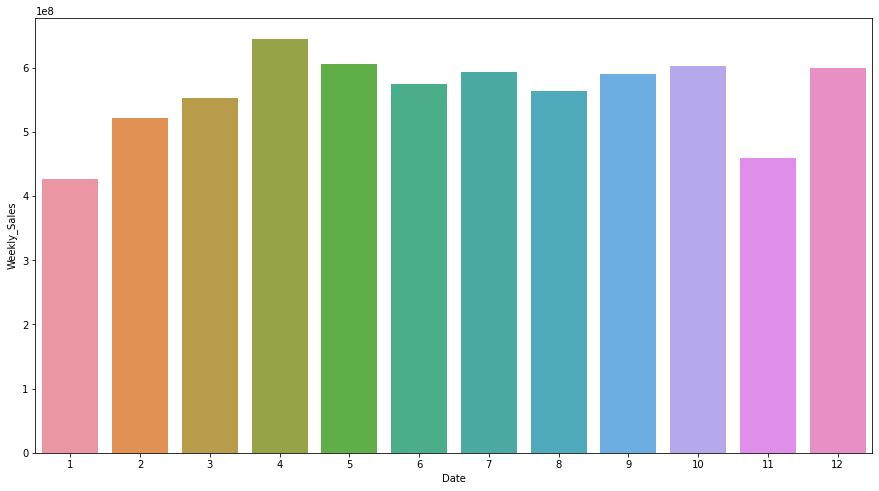

In [ ]:
monthly_sales = df_all.groupby(df_all.Date.dt.month).agg({'Weekly_Sales':'sum'})
plt.figure(figsize = (15,8))
sns.barplot(x = monthly_sales.index, y = monthly_sales.Weekly_Sales);

### Departments

In [ ]:
df_by_dept = df_all.groupby('Dept', as_index=False).agg({'Weekly_Sales':'sum'})

In [ ]:
df_by_dept

,Dept,Weekly_Sales
0,1,1.236388e+08
1,2,2.806112e+08
2,3,7.589245e+07
3,4,1.671467e+08
4,5,1.356074e+08
...,...,...
76,95,4.493202e+08
77,96,7.383392e+07
78,97,8.949651e+07
79,98,3.982892e+07


In [ ]:
df_by_dept.sort_values(by = 'Weekly_Sales', ascending = False, inplace = True)

In [ ]:
df_by_dept.reset_index(drop=True, inplace=True)

In [ ]:
df_by_dept

,Dept,Weekly_Sales
0,92,4.839433e+08
1,95,4.493202e+08
2,38,3.931181e+08
3,72,3.057252e+08
4,90,2.910685e+08
...,...,...
76,51,3.057283e+04
77,78,1.714710e+03
78,39,1.779800e+02
79,43,1.432000e+01


best and worst performing departments can be seen above

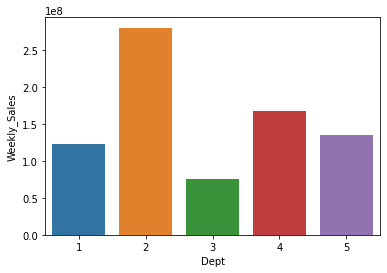

In [ ]:
sns.barplot(y='Weekly_Sales', x='Dept', data=df_by_dept[:5]);

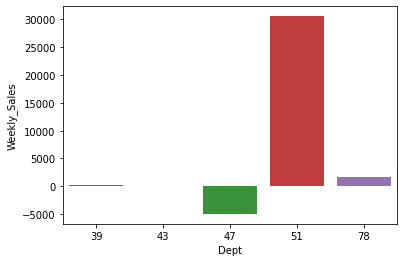

In [ ]:
sns.barplot(y='Weekly_Sales', x='Dept', data=df_by_dept[-5:]);

# Forecasting using the Holt-Winters Model

Exponential smoothing is a technique for smoothening time series data by giving different weights which are exponentially decreasing over time, unlike simple moving average method which assigns equal weightage to all observations.
Holt Winters exponential smoothening applies exponential smoothing three times, usually done when high frequency signal has to be removed.

### Train and test on 2012 data to determine accuracy

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [21]:
fit_model = ExponentialSmoothing(df_by_date_new['Weekly_Sales'][:120],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

prediction = fit_model.forecast(34)
prediction

2012-04-29    4.430014e+07
2012-05-06    4.830861e+07
2012-05-13    4.584694e+07
2012-05-20    4.455206e+07
2012-05-27    4.598154e+07
2012-06-03    4.745504e+07
2012-06-10    4.798261e+07
2012-06-17    4.790966e+07
2012-06-24    4.639954e+07
2012-07-01    4.391295e+07
2012-07-08    4.792269e+07
2012-07-15    4.616674e+07
2012-07-22    4.578205e+07
2012-07-29    4.432409e+07
2012-08-05    4.726275e+07
2012-08-12    4.725167e+07
2012-08-19    4.736134e+07
2012-08-26    4.764000e+07
2012-09-02    4.719190e+07
2012-09-09    4.725656e+07
2012-09-16    4.922033e+07
2012-09-23    4.272830e+07
2012-09-30    4.275668e+07
2012-10-07    4.762575e+07
2012-10-14    4.514605e+07
2012-10-21    4.573771e+07
2012-10-28    4.575267e+07
2012-11-04    4.631955e+07
2012-11-11    4.820248e+07
2012-11-18    4.632473e+07
2012-11-25    6.650515e+07
2012-12-02    4.634033e+07
2012-12-09    4.623113e+07
2012-12-16    6.028879e+07
Freq: W-SUN, dtype: float64

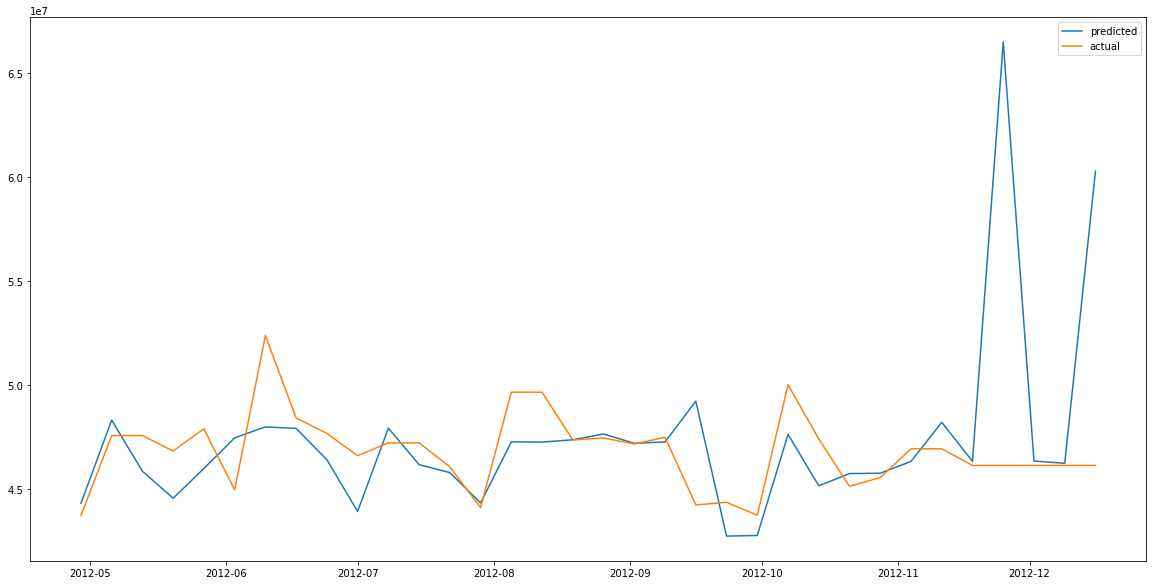

In [22]:
plt.figure(figsize=(20,10))
plt.plot(df_by_date_new.index[120:], prediction, label = 'predicted')
plt.plot(df_by_date_new.index[120:], df_by_date_new.Weekly_Sales[120:], label = 'actual')
plt.legend();

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Mean Absolute Percentage Error = {a}%".format(a=mean_absolute_percentage_error(df_by_date_new.Weekly_Sales[120:],prediction)))

Mean Absolute Percentage Error = 4.786445001829046%


### Forecasting 2013 sales

In [ ]:
fit_model = ExponentialSmoothing(df_by_date_new['Weekly_Sales'][:-2],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

future_prediction = fit_model.forecast(56)
future_prediction

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


2012-12-09    4.505660e+07
2012-12-16    5.929613e+07
2012-12-23    7.677893e+07
2012-12-30    4.339485e+07
2013-01-06    4.585048e+07
2013-01-13    4.055660e+07
2013-01-20    4.065700e+07
2013-01-27    3.887275e+07
2013-02-03    4.572178e+07
2013-02-10    4.812657e+07
2013-02-17    4.826579e+07
2013-02-24    4.372496e+07
2013-03-03    4.508220e+07
2013-03-10    4.544090e+07
2013-03-17    4.471307e+07
2013-03-24    4.276371e+07
2013-03-31    4.402774e+07
2013-04-07    4.555518e+07
2013-04-14    4.489303e+07
2013-04-21    4.404180e+07
2013-04-28    4.223444e+07
2013-05-05    4.599239e+07
2013-05-12    4.538030e+07
2013-05-19    4.442659e+07
2013-05-26    4.552566e+07
2013-06-02    4.362120e+07
2013-06-09    4.929049e+07
2013-06-16    4.612279e+07
2013-06-23    4.514523e+07
2013-06-30    4.380504e+07
2013-07-07    4.506481e+07
2013-07-14    4.459221e+07
2013-07-21    4.353146e+07
2013-07-28    4.170285e+07
2013-08-04    4.647859e+07
2013-08-11    4.633096e+07
2013-08-18    4.456831e+07
2

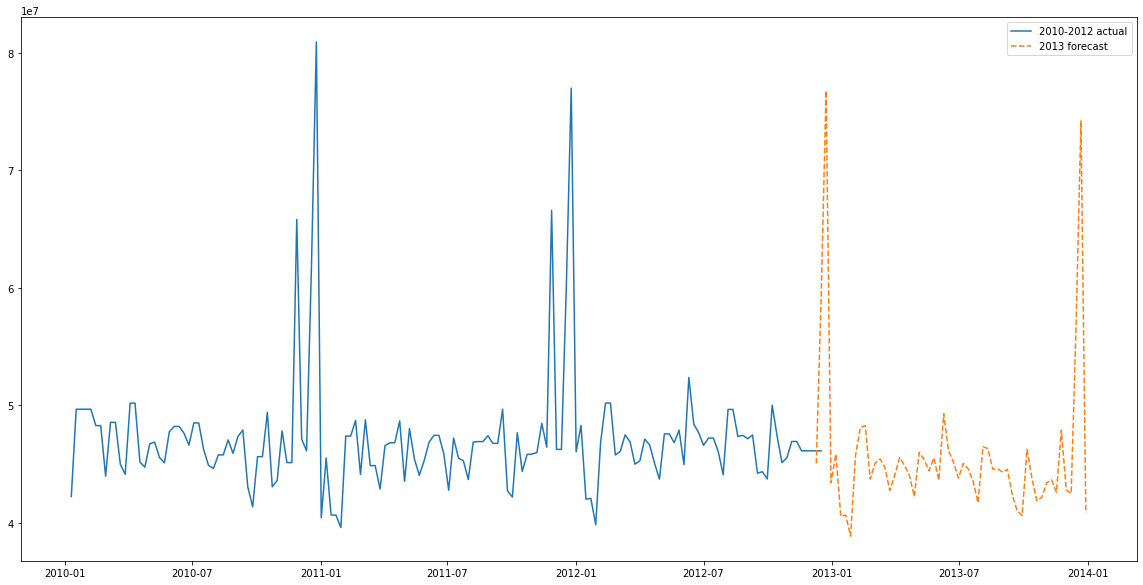

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df_by_date_new.index, df_by_date_new.Weekly_Sales)
plt.plot(future_prediction, '--')
plt.legend(['2010-2012 actual', '2013 forecast'])